# Immersion Week Term 2: What is the Network Structure of the LIS MASc?

![poster](network_affects.jpeg)

![bridge](bridges.png)

Network theory emerged in the 18th century, when Leonhard Euler solved the famous "Seven Bridges of Königsberg" problem by inventing graph theory, reducing the city's layout to a set of nodes (land masses) and edges (bridges). For nearly 200 years, networks were studied primarily through this mathematical lens, focusing on regular, lattice-like structures. The field radically transformed in the mid-20th century with pioneers like Paul Erdős and Alfréd Rényi, who introduced random graph theory to model complex systems, and Stanley Milgram, whose "small-world" experiments revealed the social "six degrees of separation." However, the true revolution arrived in the late 1990s with digital computing. Researchers like Duncan Watts, Steven Strogatz, and Albert-László Barabási analyzed massive, real-world datasets—from the World Wide Web to metabolic pathways—and discovered that most natural networks are neither completely regular nor purely random, but instead follow universal laws, such as the scale-free structure where a few "hub" nodes hold the system together, fundamentally changing how we view the interconnected world.

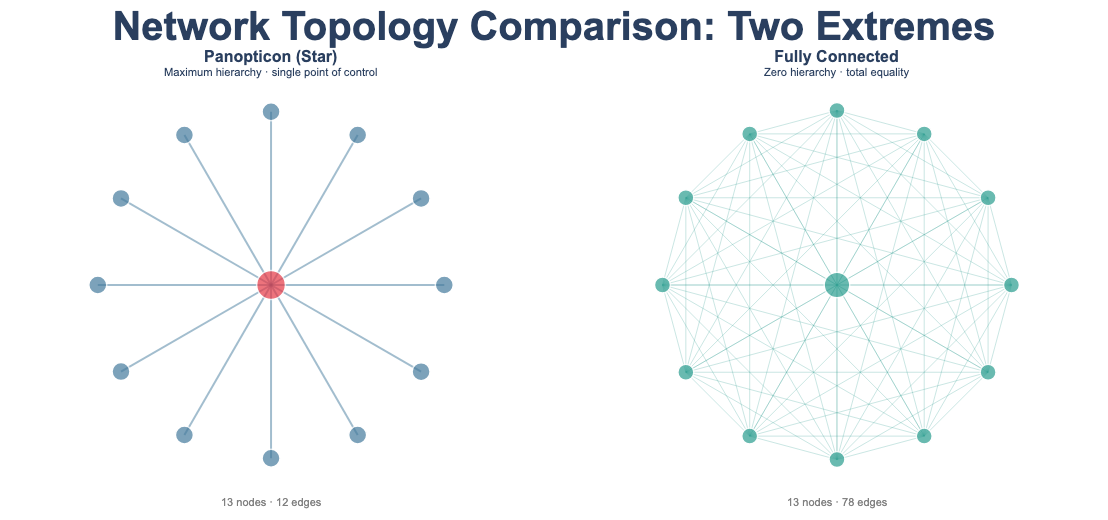

In [31]:
# --- Parameters ---
N = 12  # number of peripheral nodes (adjust as you like)

# --- 1. Build graphs ---
# Panopticon: star graph (one hub connected to all others, no other edges)
G_star = nx.star_graph(N)

# Fully connected: complete graph (every node connected to every other)
G_complete = nx.complete_graph(N + 1)  # same node count for fair comparison

# --- 2. Layout: circular with hub in centre ---
def circular_layout_with_center(n_peripheral):
    """Place node 0 at centre, rest on a circle."""
    pos = {0: (0.0, 0.0)}
    for i in range(1, n_peripheral + 1):
        angle = 2 * np.pi * (i - 1) / n_peripheral
        pos[i] = (np.cos(angle), np.sin(angle))
    return pos

pos = circular_layout_with_center(N)

# --- 3. Helper to build Plotly traces from a graph + positions ---
def make_edge_traces(G, pos, color="rgba(150,150,150,0.4)", width=1.2):
    edge_x, edge_y = [], []
    for u, v in G.edges():
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]
    return go.Scatter(
        x=edge_x, y=edge_y,
        mode="lines",
        line=dict(width=width, color=color),
        hoverinfo="none",
    )

def make_node_trace(G, pos, hub_color="#E63946", node_color="#457B9D", size=18):
    node_x = [pos[n][0] for n in G.nodes()]
    node_y = [pos[n][1] for n in G.nodes()]
    colors = [hub_color if n == 0 else node_color for n in G.nodes()]
    sizes  = [size * 1.6 if n == 0 else size for n in G.nodes()]
    return go.Scatter(
        x=node_x, y=node_y,
        mode="markers",
        marker=dict(size=sizes, color=colors,
                    line=dict(width=1.5, color="white")),
        hoverinfo="none",
    )

# --- 4. Assemble figure with subplots ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        "<b>Panopticon (Star)</b><br><sup>Maximum hierarchy · single point of control</sup>",
        "<b>Fully Connected</b><br><sup>Zero hierarchy · total equality</sup>",
    ),
    horizontal_spacing=0.08,
)

# Panopticon (left)
fig.add_trace(make_edge_traces(G_star, pos, color="rgba(69,123,157,0.5)", width=2), row=1, col=1)
fig.add_trace(make_node_trace(G_star, pos), row=1, col=1)

# Fully connected (right) – use a different accent to visually distinguish
fig.add_trace(make_edge_traces(G_complete, pos, color="rgba(42,157,143,0.25)", width=1), row=1, col=2)
fig.add_trace(make_node_trace(G_complete, pos, hub_color="#2A9D8F", node_color="#2A9D8F", size=16), row=1, col=2)

# --- 5. Styling ---
axis_defaults = dict(
    showgrid=False, zeroline=False, showticklabels=False,
    showline=False, scaleratio=1,
)

fig.update_xaxes(**axis_defaults)
fig.update_yaxes(**axis_defaults, scaleanchor="x")   # col 1
fig.update_yaxes(**axis_defaults, scaleanchor="x2", row=1, col=2)  # col 2

fig.update_layout(
    width=1000, height=520,
    showlegend=False,
    margin=dict(l=30, r=30, t=80, b=30),
    paper_bgcolor="white",
    plot_bgcolor="white",
    title=dict(
        text="<b>Network Topology Comparison: Two Extremes</b>",
        x=0.5, font=dict(size=40),
    ),
    font=dict(family="Arial, sans-serif"),
)

# Add edge-count annotations
for col, G, label in [(1, G_star, "star"), (2, G_complete, "complete")]:
    n_edges = G.number_of_edges()
    fig.add_annotation(
        text=f"{G.number_of_nodes()} nodes · {n_edges} edges",
        xref=f"x{col if col > 1 else ''} domain", yref=f"y{col if col > 1 else ''} domain",
        x=0.5, y=-0.05, showarrow=False,
        font=dict(size=11, color="gray"),
    )

fig.show()

## Network Structure of the LIS MASc Cohort

This notebook builds **text-similarity networks** from the MASc cohort survey responses and uses them to introduce core concepts in network theory. Each student becomes a node; edges connect students whose writing is similar.

We construct **two networks**:
1. **Short-text network** — based on the ~120-word description of intellectual interests and values.
2. **Long-text network** — based on the longer reflective writing piece (e.g. Critical Reflection, capstone plan).

The notebook is designed to be **re-run as new survey responses arrive** — it reads whatever rows are present in the Excel file.

### Concepts covered
1. Nodes and edges (adjacency matrices)
2. Degree and degree distribution
3. Paths and distances
4. Clustering coefficient
5. Centrality and outliers

In [32]:
# ── Setup & Data Loading ──────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ── Load data ─────────────────────────────────────────────────────────────────
DATA_FILE = "What's the network structure of the LIS MASc cohort_(1-20).xlsx"
df_raw = pd.read_excel(DATA_FILE)

# Column references (by position — resilient to minor name changes)
COL_PSEUDO = df_raw.columns[6]   # pseudonym
COL_SHORT  = df_raw.columns[7]   # short text (~120 words)
COL_LONG   = df_raw.columns[8]   # long reflective text
COL_QUESTION = df_raw.columns[9] # fun question

# Build a clean working dataframe
df = df_raw[[COL_PSEUDO, COL_SHORT, COL_LONG, COL_QUESTION]].copy()
df.columns = ['pseudonym', 'short_text', 'long_text', 'question']

# Fill missing text with empty strings
df['short_text'] = df['short_text'].fillna('').astype(str)
df['long_text']  = df['long_text'].fillna('').astype(str)

# Flag very short entries
df['short_len'] = df['short_text'].str.len()
df['long_len']  = df['long_text'].str.len()

print(f"Loaded {len(df)} respondents from {DATA_FILE}\n")
display(df[['pseudonym', 'short_len', 'long_len']].style
        .set_caption('Respondent summary')
        .bar(subset=['short_len', 'long_len'], color='#b3d1ff'))

Loaded 20 respondents from What's the network structure of the LIS MASc cohort_(1-20).xlsx



,pseudonym,short_len,long_len
0,Hotspur,250,4000
1,Goose washing feet,710,4000
2,Orp Koob,229,3995
3,Poppy,683,3529
4,peridot,216,4000
5,Palmer's Cocoa Butter Formula,580,2724
6,Rubberneck,268,3300
7,Iggle Piggle,369,4000
8,Esquie,608,4000
9,David Moyes,623,1


## Text Preprocessing: TF-IDF and Cosine Similarity

### TF-IDF (Term Frequency – Inverse Document Frequency)

TF-IDF converts raw text into numerical vectors that capture how important each word is to a particular document *relative to the whole corpus*.

For a term $t$ in document $d$ within a corpus $D$:

$$\text{tf}(t, d) = \frac{\text{count of } t \text{ in } d}{\text{total terms in } d}$$

$$\text{idf}(t, D) = \log \frac{|D|}{1 + |\{d \in D : t \in d\}|}$$

$$\text{tf-idf}(t, d, D) = \text{tf}(t, d) \times \text{idf}(t, D)$$

Words that appear frequently in one document but rarely across the corpus receive high TF-IDF scores — they are *distinctive* to that document.



In [33]:
# ── Toy Example: TF-IDF and Cosine Similarity ────────────────────────────────
# Three short documents about different topics.

toy_docs = [
    "The cat sat on the mat and the cat purred",
    "The dog chased the cat across the garden",
    "Python is a popular programming language for data science"
]
toy_labels = ["Doc A (cat)", "Doc B (cat & dog)", "Doc C (programming)"]

# Compute TF-IDF
toy_vec = TfidfVectorizer()
toy_tfidf = toy_vec.fit_transform(toy_docs)

# Show the TF-IDF matrix: each row is a document, each column is a word
tfidf_df = pd.DataFrame(
    toy_tfidf.toarray().round(3),
    index=toy_labels,
    columns=toy_vec.get_feature_names_out()
)
print("TF-IDF matrix (rows = documents, columns = words):")
display(tfidf_df.style.background_gradient(cmap='YlOrRd', axis=None)
        .format('{:.3f}'))

# Compute pairwise cosine similarity
toy_sim = cosine_similarity(toy_tfidf)
sim_df = pd.DataFrame(toy_sim.round(3), index=toy_labels, columns=toy_labels)

print("\nCosine similarity between documents:")
display(sim_df.style.background_gradient(cmap='Blues').format('{:.3f}'))

print("\nDocs A and B share the word 'cat' → moderate similarity (≈0.3).")
print("Doc C shares no words with A or B → similarity ≈ 0.")
print("Each document has similarity 1.0 with itself (the diagonal).")

TF-IDF matrix (rows = documents, columns = words):


,across,and,cat,chased,data,dog,for,garden,is,language,mat,on,popular,programming,purred,python,sat,science,the
Doc A (cat),0.000,0.283,0.430,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.283,0.283,0.000,0.000,0.283,0.000,0.283,0.000,0.645
Doc B (cat & dog),0.320,0.000,0.243,0.320,0.000,0.320,0.000,0.320,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.729
Doc C (programming),0.000,0.000,0.000,0.000,0.354,0.000,0.354,0.000,0.354,0.354,0.000,0.000,0.354,0.354,0.000,0.354,0.000,0.354,0.000



Cosine similarity between documents:


,Doc A (cat),Doc B (cat & dog),Doc C (programming)
Doc A (cat),1.000,0.575,0.000
Doc B (cat & dog),0.575,1.000,0.000
Doc C (programming),0.000,0.000,1.000



Docs A and B share the word 'cat' → moderate similarity (≈0.3).
Doc C shares no words with A or B → similarity ≈ 0.
Each document has similarity 1.0 with itself (the diagonal).


In [34]:
# ── Applied: TF-IDF & Cosine Similarity on Student Data ──────────────────────

def compute_similarity(texts, names):
    """Compute TF-IDF and pairwise cosine similarity for a list of texts."""
    vectorizer = TfidfVectorizer(stop_words='english', min_df=1)
    tfidf_matrix = vectorizer.fit_transform(texts)
    sim_matrix = cosine_similarity(tfidf_matrix)
    np.fill_diagonal(sim_matrix, 0)  # zero the diagonal — no self-loops in our network
    return pd.DataFrame(sim_matrix, index=names, columns=names)

names = df['pseudonym'].tolist()

sim_short = compute_similarity(df['short_text'], names)
sim_long  = compute_similarity(df['long_text'], names)

print("Short-text similarity matrix:")
print("(Diagonal is zeroed out — a student's similarity with themselves is always")
print(" 1.0, but self-loops are meaningless in our network, so we set it to 0.)\n")
display(sim_short.style.background_gradient(cmap='Blues', vmin=0, vmax=0.5)
        .format('{:.3f}').set_caption('Cosine similarity — short text'))

print("\nLong-text similarity matrix:")
display(sim_long.style.background_gradient(cmap='Oranges', vmin=0, vmax=0.5)
        .format('{:.3f}').set_caption('Cosine similarity — long text'))

Short-text similarity matrix:
(Diagonal is zeroed out — a student's similarity with themselves is always
 1.0, but self-loops are meaningless in our network, so we set it to 0.)



,Hotspur,Goose washing feet,Orp Koob,Poppy,peridot,Palmer's Cocoa Butter Formula,Rubberneck,Iggle Piggle,Esquie,David Moyes,Jammy,slime,PrimeOrange77,Tiger,Sesquatch,Barbara,Utopia,Petrichor,Aitch,valencia-engine
Hotspur,0.000,0.000,0.016,0.000,0.066,0.000,0.061,0.072,0.027,0.047,0.045,0.018,0.000,0.013,0.054,0.090,0.025,0.023,0.008,0.077
Goose washing feet,0.000,0.000,0.012,0.044,0.000,0.092,0.026,0.000,0.048,0.140,0.012,0.026,0.011,0.045,0.016,0.080,0.044,0.079,0.036,0.027
Orp Koob,0.016,0.012,0.000,0.090,0.000,0.000,0.017,0.059,0.036,0.039,0.032,0.000,0.000,0.071,0.000,0.033,0.000,0.011,0.009,0.134
Poppy,0.000,0.044,0.090,0.000,0.101,0.044,0.022,0.030,0.045,0.157,0.019,0.029,0.024,0.039,0.054,0.037,0.111,0.096,0.131,0.067
peridot,0.066,0.000,0.000,0.101,0.000,0.000,0.000,0.048,0.084,0.049,0.000,0.018,0.000,0.037,0.055,0.027,0.097,0.000,0.085,0.037
Palmer's Cocoa Butter Formula,0.000,0.092,0.000,0.044,0.000,0.000,0.056,0.045,0.061,0.104,0.000,0.037,0.024,0.026,0.000,0.012,0.057,0.028,0.017,0.017
Rubberneck,0.061,0.026,0.017,0.022,0.000,0.056,0.000,0.000,0.011,0.050,0.009,0.037,0.062,0.131,0.000,0.010,0.092,0.029,0.021,0.033
Iggle Piggle,0.072,0.000,0.059,0.030,0.048,0.045,0.000,0.000,0.032,0.018,0.133,0.057,0.000,0.000,0.000,0.090,0.049,0.000,0.045,0.057
Esquie,0.027,0.048,0.036,0.045,0.084,0.061,0.011,0.032,0.000,0.042,0.041,0.000,0.018,0.067,0.000,0.067,0.028,0.031,0.034,0.064
David Moyes,0.047,0.140,0.039,0.157,0.049,0.104,0.050,0.018,0.042,0.000,0.007,0.135,0.140,0.074,0.018,0.098,0.153,0.156,0.072,0.123



Long-text similarity matrix:


,Hotspur,Goose washing feet,Orp Koob,Poppy,peridot,Palmer's Cocoa Butter Formula,Rubberneck,Iggle Piggle,Esquie,David Moyes,Jammy,slime,PrimeOrange77,Tiger,Sesquatch,Barbara,Utopia,Petrichor,Aitch,valencia-engine
Hotspur,0.000,0.073,0.055,0.043,0.027,0.188,0.025,0.012,0.048,0.000,0.006,0.074,0.058,0.040,0.023,0.076,0.075,0.119,0.033,0.091
Goose washing feet,0.073,0.000,0.049,0.053,0.011,0.017,0.010,0.010,0.030,0.000,0.035,0.045,0.025,0.054,0.026,0.063,0.024,0.076,0.019,0.038
Orp Koob,0.055,0.049,0.000,0.024,0.008,0.032,0.022,0.015,0.019,0.000,0.000,0.050,0.016,0.020,0.017,0.027,0.033,0.038,0.008,0.058
Poppy,0.043,0.053,0.024,0.000,0.022,0.026,0.033,0.010,0.026,0.000,0.000,0.013,0.033,0.030,0.008,0.043,0.041,0.045,0.033,0.028
peridot,0.027,0.011,0.008,0.022,0.000,0.015,0.013,0.016,0.019,0.000,0.005,0.020,0.014,0.010,0.000,0.011,0.028,0.043,0.001,0.016
Palmer's Cocoa Butter Formula,0.188,0.017,0.032,0.026,0.015,0.000,0.007,0.010,0.057,0.000,0.010,0.005,0.027,0.030,0.013,0.036,0.040,0.051,0.101,0.088
Rubberneck,0.025,0.010,0.022,0.033,0.013,0.007,0.000,0.034,0.020,0.000,0.000,0.005,0.008,0.023,0.017,0.007,0.037,0.021,0.015,0.008
Iggle Piggle,0.012,0.010,0.015,0.010,0.016,0.010,0.034,0.000,0.045,0.000,0.008,0.008,0.024,0.020,0.016,0.013,0.034,0.014,0.015,0.009
Esquie,0.048,0.030,0.019,0.026,0.019,0.057,0.020,0.045,0.000,0.000,0.023,0.031,0.028,0.053,0.059,0.035,0.015,0.038,0.022,0.040
David Moyes,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Network Construction

### Formal Definition

A **weighted undirected graph** is a triple $G = (V, E, w)$ where:
- $V$ is the set of **nodes** (here: students),
- $E \subseteq \binom{V}{2}$ is the set of **edges** (pairs of students),
- $w: E \to \mathbb{R}_{>0}$ assigns a positive **weight** to each edge (here: cosine similarity).

We apply a **threshold** $\tau$: an edge $(i, j)$ exists only if $\text{sim}(i, j) \geq \tau$. Adjusting $\tau$ controls how connected the network is — low thresholds create dense networks (many weak connections), high thresholds create sparse ones (only strong connections).

In [35]:
# ── Toy Example: Threshold and Graph Construction ─────────────────────────────
# We'll use the 3-document similarity matrix from above to build tiny graphs
# at different thresholds.

toy_sim_matrix = cosine_similarity(toy_tfidf)
np.fill_diagonal(toy_sim_matrix, 0)
toy_sim_df = pd.DataFrame(toy_sim_matrix, index=toy_labels, columns=toy_labels)

print("Similarity matrix (diagonal zeroed):")
display(toy_sim_df.round(3))

for tau in [0.0, 0.15, 0.40]:
    G_toy = nx.Graph()
    G_toy.add_nodes_from(toy_labels)
    for i, n1 in enumerate(toy_labels):
        for j, n2 in enumerate(toy_labels):
            if j > i and toy_sim_df.iloc[i, j] >= tau:
                G_toy.add_edge(n1, n2, weight=round(toy_sim_df.iloc[i, j], 3))
    edges_str = ', '.join(f"{u}–{v} ({d['weight']:.2f})" for u, v, d in G_toy.edges(data=True))
    print(f"\n  τ = {tau:.2f} → {G_toy.number_of_edges()} edge(s): {edges_str or '(none)'}")

print("\nAt τ=0.0 Docs A & B are connected (they share 'cat').")
print("At τ=0.40 no edges survive — no pair is similar enough.")
print("The threshold acts as a dial between a dense and a sparse network.")

Similarity matrix (diagonal zeroed):


,Doc A (cat),Doc B (cat & dog),Doc C (programming)
Doc A (cat),0.000,0.575,0.0
Doc B (cat & dog),0.575,0.000,0.0
Doc C (programming),0.000,0.000,0.0



  τ = 0.00 → 3 edge(s): Doc A (cat)–Doc B (cat & dog) (0.57), Doc A (cat)–Doc C (programming) (0.00), Doc B (cat & dog)–Doc C (programming) (0.00)

  τ = 0.15 → 1 edge(s): Doc A (cat)–Doc B (cat & dog) (0.57)

  τ = 0.40 → 1 edge(s): Doc A (cat)–Doc B (cat & dog) (0.57)

At τ=0.0 Docs A & B are connected (they share 'cat').
At τ=0.40 no edges survive — no pair is similar enough.
The threshold acts as a dial between a dense and a sparse network.


In [36]:
# ── Helper functions (used throughout the notebook) ───────────────────────────

def build_graph(sim_df, threshold):
    """Build a weighted NetworkX graph from a similarity matrix at a given threshold."""
    G = nx.Graph()
    G.add_nodes_from(sim_df.index)
    for i, n1 in enumerate(sim_df.index):
        for j, n2 in enumerate(sim_df.columns):
            if j > i and sim_df.iloc[i, j] >= threshold:
                G.add_edge(n1, n2, weight=sim_df.iloc[i, j])
    return G


def plot_network(G, title, color='#4a90d9'):
    """Create a Plotly figure of the network using a spring layout."""
    pos = nx.spring_layout(G, seed=42, k=2/np.sqrt(max(len(G), 1)))

    # Edges
    edge_traces = []
    for u, v, d in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        weight = d.get('weight', 0)
        edge_traces.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            mode='lines',
            line=dict(width=max(0.5, weight * 6), color='rgba(150,150,150,0.5)'),
            hoverinfo='text',
            text=f"{u} ↔ {v}: {weight:.3f}",
            showlegend=False
        ))

    # Nodes
    node_x = [pos[n][0] for n in G.nodes()]
    node_y = [pos[n][1] for n in G.nodes()]
    degrees = [G.degree(n) for n in G.nodes()]
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=list(G.nodes()),
        textposition='top center',
        textfont=dict(size=10),
        marker=dict(
            size=[max(15, 8 + d * 3) for d in degrees],
            color=degrees,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='Degree'),
            line=dict(width=1, color='white')
        ),
        hoverinfo='text',
        hovertext=[f"{n}\nDegree: {G.degree(n)}" for n in G.nodes()],
        showlegend=False
    )

    fig = go.Figure(data=edge_traces + [node_trace])
    fig.update_layout(
        title=title,
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=750, height=550,
        margin=dict(l=20, r=20, t=50, b=20),
        plot_bgcolor='white'
    )
    return fig


def build_and_plot(sim_df, threshold, label, color='#4a90d9'):
    """Build graph at threshold and plot it. Returns the graph."""
    G = build_graph(sim_df, threshold)
    fig = plot_network(G, f"{label} (threshold τ = {threshold:.2f})", color)
    fig.show()
    print(f"  Nodes: {G.number_of_nodes()}  |  Edges: {G.number_of_edges()}")
    return G

SHORT-TEXT NETWORK


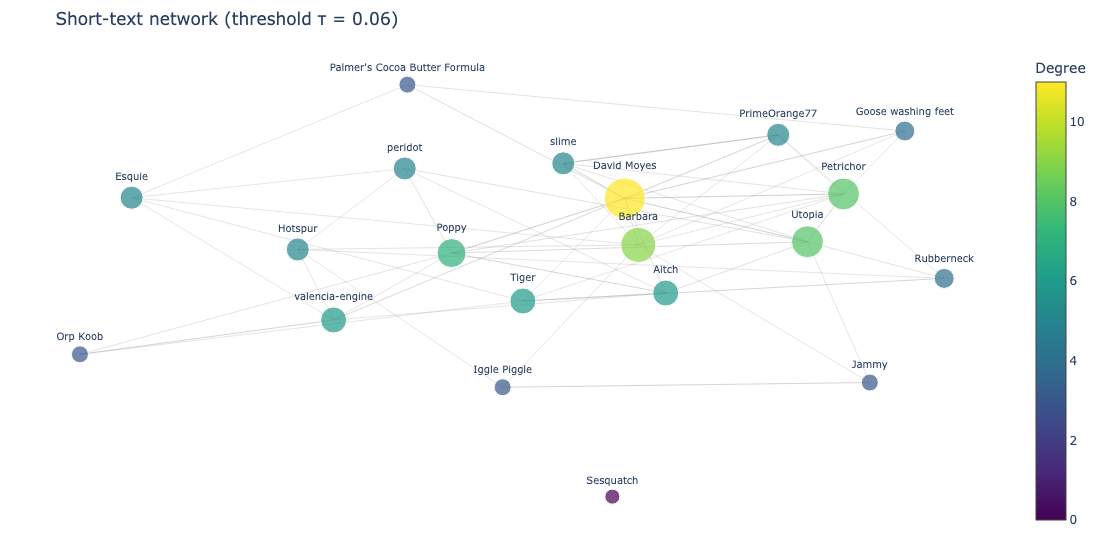

  Nodes: 20  |  Edges: 53

LONG-TEXT NETWORK


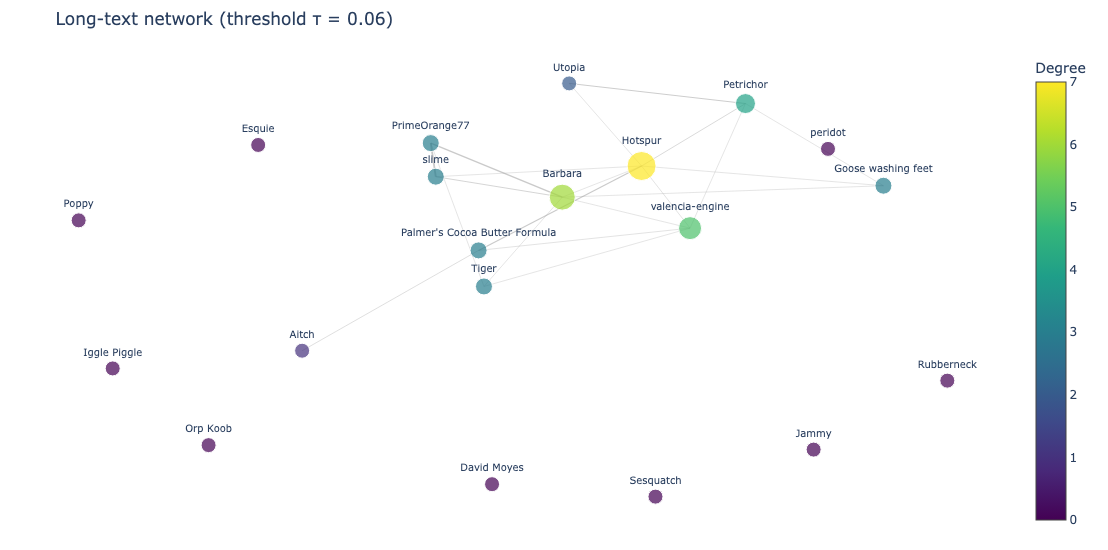

  Nodes: 20  |  Edges: 20


In [37]:
# ── Applied: Student Networks ─────────────────────────────────────────────────
# Sensible defaults: short texts share more common vocabulary → higher threshold
THRESH_SHORT = 0.06
THRESH_LONG  = 0.06

print("=" * 60)
print("SHORT-TEXT NETWORK")
print("=" * 60)
G_short = build_and_plot(sim_short, THRESH_SHORT, 'Short-text network')

print("\n" + "=" * 60)
print("LONG-TEXT NETWORK")
print("=" * 60)
G_long = build_and_plot(sim_long, THRESH_LONG, 'Long-text network')

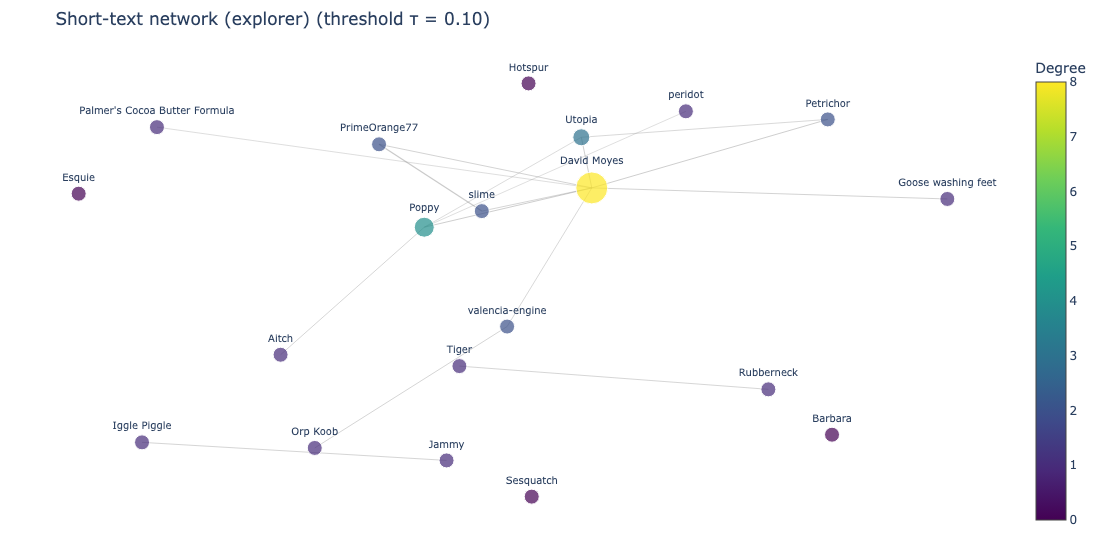

  Nodes: 20  |  Edges: 16


In [41]:
# ── Threshold Explorer ────────────────────────────────────────────────────────
# Use this cell to experiment with different thresholds.
# Change the values below and re-run to see how the network changes.

EXPLORE_THRESHOLD = 0.1   # ← change this value
EXPLORE_WHICH = 'short'    # ← 'short' or 'long'

sim = sim_short if EXPLORE_WHICH == 'short' else sim_long
label = 'Short-text' if EXPLORE_WHICH == 'short' else 'Long-text'
G_explore = build_and_plot(sim, EXPLORE_THRESHOLD, f'{label} network (explorer)')

---

## 1. Nodes and Edges

### Formal Definitions

- A **node** (or vertex) $v \in V$ represents an entity — here, a student.
- An **edge** $e = \{u, v\} \in E$ represents a relationship — here, textual similarity above the threshold.
- The **adjacency matrix** $A$ of a graph with $n$ nodes is an $n \times n$ matrix where:

$$A_{ij} = \begin{cases} w(i,j) & \text{if } \{i,j\} \in E \\ 0 & \text{otherwise} \end{cases}$$

For unweighted graphs, $A_{ij} \in \{0, 1\}$. For weighted graphs (ours), $A_{ij}$ stores the cosine similarity.

In [42]:
# ── Toy Example: Nodes, Edges, and Adjacency Matrix ──────────────────────────
# A small network of 5 people at a party. Edges represent who talked to whom.

G_party = nx.Graph()
G_party.add_nodes_from(['Alice', 'Bob', 'Carol', 'Dan', 'Eve'])
G_party.add_edges_from([
    ('Alice', 'Bob'),    # Alice and Bob chatted
    ('Alice', 'Carol'),  # Alice and Carol chatted
    ('Bob', 'Carol'),    # Bob and Carol chatted
    ('Carol', 'Dan'),    # Carol and Dan chatted
    # Eve talked to nobody — she's an isolated node
])

print("Party network:")
print(f"  Nodes (V): {list(G_party.nodes())}")
print(f"  Edges (E): {list(G_party.edges())}")
print(f"  |V| = {G_party.number_of_nodes()}, |E| = {G_party.number_of_edges()}")

# Adjacency matrix
party_nodes = ['Alice', 'Bob', 'Carol', 'Dan', 'Eve']
adj = nx.to_pandas_adjacency(G_party, nodelist=party_nodes, dtype=int)
print("\nAdjacency matrix (unweighted — 1 means connected, 0 means not):")
display(adj.style.background_gradient(cmap='Blues', vmin=0, vmax=1))

print("\nNotice: the matrix is symmetric (Alice→Bob = Bob→Alice) and the")
print("diagonal is 0 (no self-loops). Eve's row and column are all zeros — she's isolated.")

Party network:
  Nodes (V): ['Alice', 'Bob', 'Carol', 'Dan', 'Eve']
  Edges (E): [('Alice', 'Bob'), ('Alice', 'Carol'), ('Bob', 'Carol'), ('Carol', 'Dan')]
  |V| = 5, |E| = 4

Adjacency matrix (unweighted — 1 means connected, 0 means not):


,Alice,Bob,Carol,Dan,Eve
Alice,0,1,1,0,0
Bob,1,0,1,0,0
Carol,1,1,0,1,0
Dan,0,0,1,0,0
Eve,0,0,0,0,0



Notice: the matrix is symmetric (Alice→Bob = Bob→Alice) and the
diagonal is 0 (no self-loops). Eve's row and column are all zeros — she's isolated.


SHORT-TEXT NETWORK


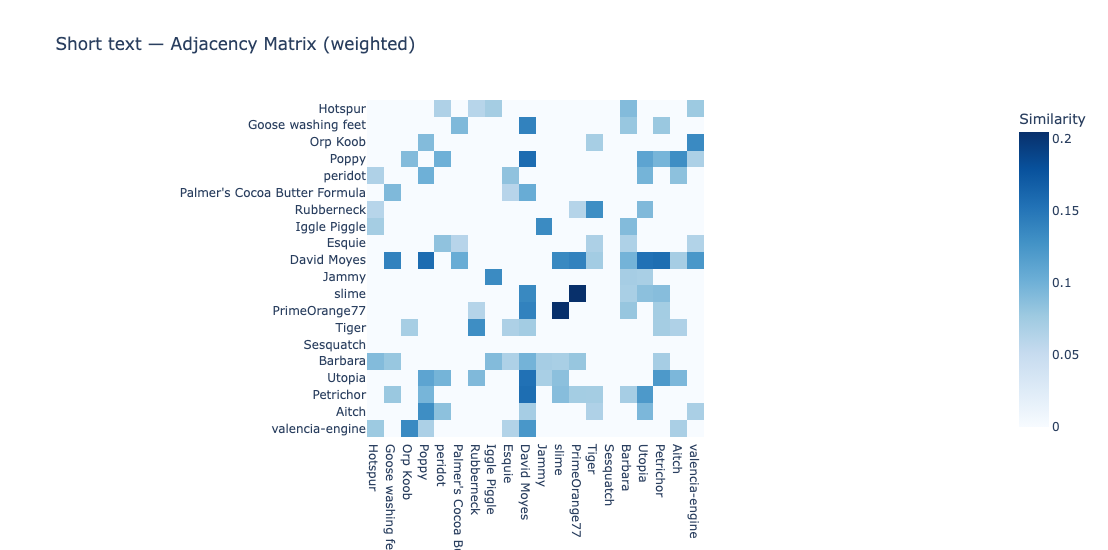


Short text — Edge list (53 edges), sorted by weight:


,Student A,Student B,Similarity
0,slime,PrimeOrange77,0.204
1,Poppy,David Moyes,0.157
2,David Moyes,Petrichor,0.156
3,David Moyes,Utopia,0.153
4,Goose washing feet,David Moyes,0.140
5,David Moyes,PrimeOrange77,0.140
6,David Moyes,slime,0.135
7,Orp Koob,valencia-engine,0.134
8,Iggle Piggle,Jammy,0.133
9,Poppy,Aitch,0.131



  Nodes: 20  |  Edges: 53

------------------------------------------------------------

LONG-TEXT NETWORK


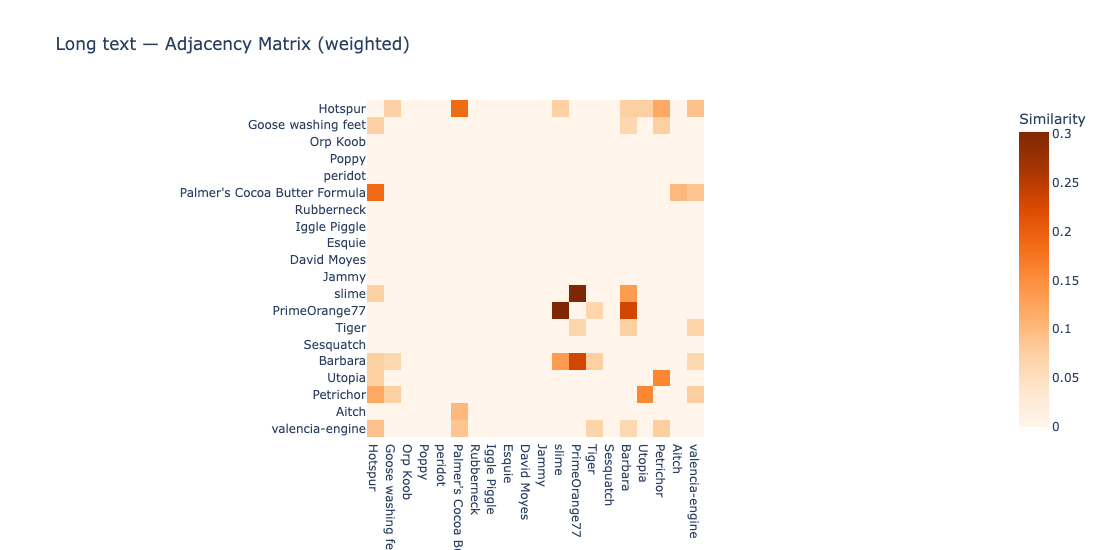


Long text — Edge list (20 edges), sorted by weight:


,Student A,Student B,Similarity
0,slime,PrimeOrange77,0.302
1,PrimeOrange77,Barbara,0.231
2,Hotspur,Palmer's Cocoa Butter Formula,0.188
3,Utopia,Petrichor,0.158
4,slime,Barbara,0.135
5,Hotspur,Petrichor,0.119
6,Palmer's Cocoa Butter Formula,Aitch,0.101
7,Hotspur,valencia-engine,0.091
8,Palmer's Cocoa Butter Formula,valencia-engine,0.088
9,Petrichor,valencia-engine,0.077



  Nodes: 20  |  Edges: 20


In [43]:
# ── Applied: Nodes & Edges in Student Networks ───────────────────────────────

def show_adjacency_and_edges(G, label, cmap='Blues'):
    """Display adjacency matrix heatmap and edge list for a graph."""
    nodes = list(G.nodes())
    adj = nx.to_pandas_adjacency(G, nodelist=nodes)

    # Adjacency heatmap
    fig = px.imshow(
        adj.values, x=nodes, y=nodes,
        color_continuous_scale=cmap,
        title=f'{label} — Adjacency Matrix (weighted)',
        labels=dict(color='Similarity')
    )
    fig.update_layout(width=650, height=550)
    fig.show()

    # Edge list
    edges = [(u, v, f"{d['weight']:.3f}") for u, v, d in
             sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)]
    if edges:
        print(f"\n{label} — Edge list ({len(edges)} edges), sorted by weight:")
        edge_df = pd.DataFrame(edges, columns=['Student A', 'Student B', 'Similarity'])
        display(edge_df)
    else:
        print(f"\n{label} — No edges at this threshold.")

    print(f"\n  Nodes: {G.number_of_nodes()}  |  Edges: {G.number_of_edges()}")


print("SHORT-TEXT NETWORK")
show_adjacency_and_edges(G_short, 'Short text', 'Blues')

print("\n" + "-" * 60)
print("\nLONG-TEXT NETWORK")
show_adjacency_and_edges(G_long, 'Long text', 'Oranges')

---

## 2. Degree and Degree Distribution

### Formal Definitions

- The **degree** of a node $v$ is the number of edges incident to it: $\deg(v) = |\{u : \{u,v\} \in E\}|$.
- The **weighted degree** (or **strength**) of a node is the sum of its edge weights: $s(v) = \sum_{u: \{u,v\} \in E} w(u,v)$.
- The **degree distribution** $P(k)$ gives the fraction of nodes with degree $k$.

In a random graph (Erdos–Renyi model $G(n, p)$), the degree distribution follows a binomial distribution centred at $(n-1)p$. Deviations from this tell us the network has non-random structure.

In [44]:
# ── Toy Example: Degree ──────────────────────────────────────────────────────
# Using our party network from above.

print("Party network degrees:")
for person in party_nodes:
    nbrs = list(G_party.neighbors(person))
    print(f"  {person:6s}  deg = {G_party.degree(person)}  "
          f"(neighbours: {', '.join(nbrs) if nbrs else 'none'})")

print(f"\nMean degree: {np.mean([G_party.degree(n) for n in G_party.nodes()]):.1f}")
print("\nCarol has the highest degree (3) — she talked to the most people.")
print("Eve has degree 0 — she's isolated.")
print("\nIn a weighted network, 'strength' sums the edge weights instead of")
print("just counting edges — it distinguishes strong from weak connections.")

Party network degrees:
  Alice   deg = 2  (neighbours: Bob, Carol)
  Bob     deg = 2  (neighbours: Alice, Carol)
  Carol   deg = 3  (neighbours: Alice, Bob, Dan)
  Dan     deg = 1  (neighbours: Carol)
  Eve     deg = 0  (neighbours: none)

Mean degree: 1.6

Carol has the highest degree (3) — she talked to the most people.
Eve has degree 0 — she's isolated.

In a weighted network, 'strength' sums the edge weights instead of
just counting edges — it distinguishes strong from weak connections.


SHORT-TEXT NETWORK


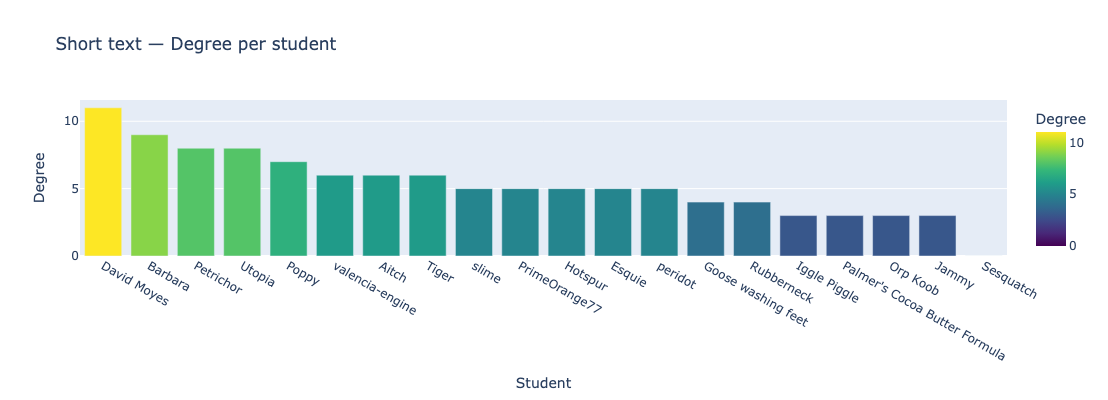

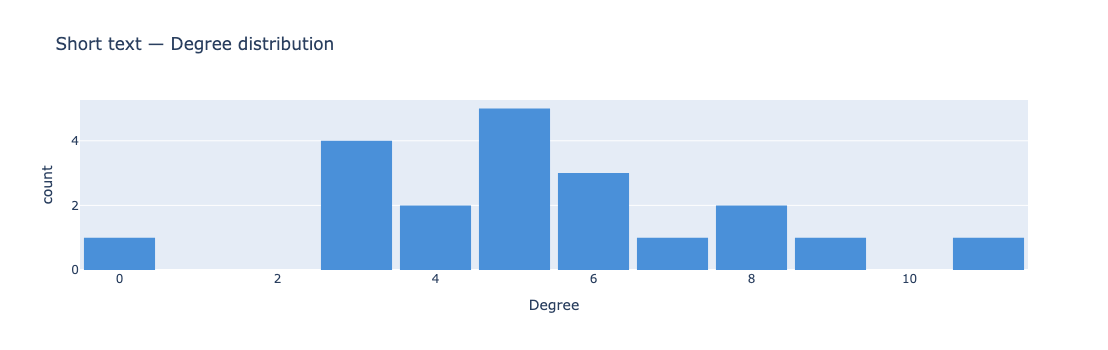

  Edge density: 0.279
  Expected degree in Erdos–Renyi G(20, 0.279): 5.3
  Actual mean degree: 5.3
  Actual std of degree: 2.43  (Erdos–Renyi std ≈ 1.95)


,Degree,Strength (weighted degree)
David Moyes,11,1.351
Barbara,9,0.718
Petrichor,8,0.757
Utopia,8,0.823
Poppy,7,0.753
valencia-engine,6,0.535
Aitch,6,0.517
Tiger,6,0.481
slime,5,0.583
PrimeOrange77,5,0.559



------------------------------------------------------------

LONG-TEXT NETWORK


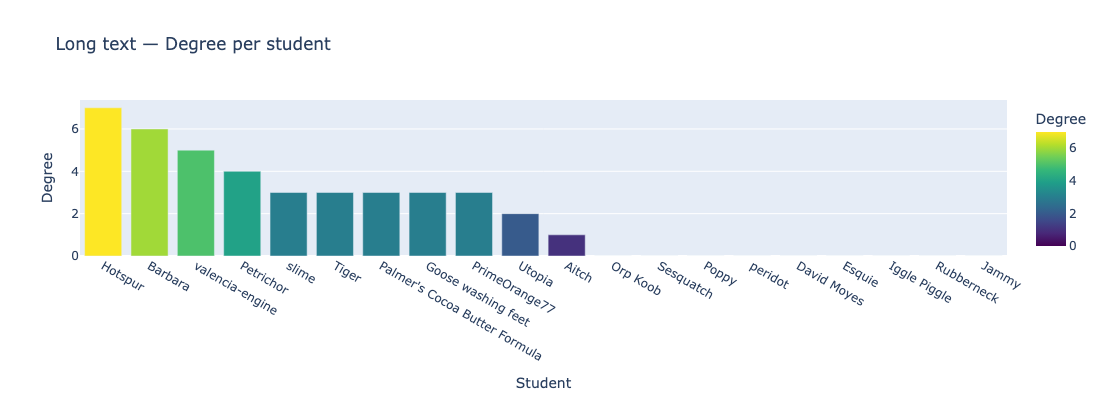

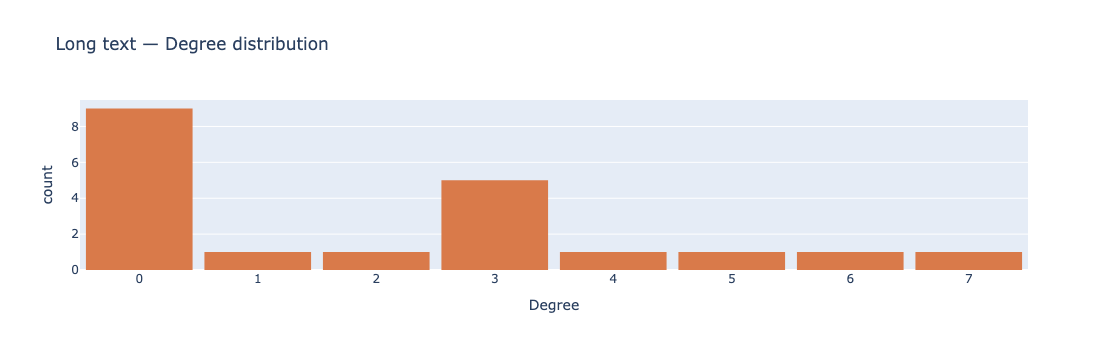

  Edge density: 0.105
  Expected degree in Erdos–Renyi G(20, 0.105): 2.0
  Actual mean degree: 2.0
  Actual std of degree: 2.19  (Erdos–Renyi std ≈ 1.34)


,Degree,Strength (weighted degree)
Hotspur,7,0.695
Barbara,6,0.642
valencia-engine,5,0.387
Petrichor,4,0.430
slime,3,0.510
Tiger,3,0.210
Palmer's Cocoa Butter Formula,3,0.376
Goose washing feet,3,0.212
PrimeOrange77,3,0.598
Utopia,2,0.233


In [45]:
# ── Applied: Degree & Degree Distribution in Student Networks ─────────────────

def degree_analysis(G, label, color):
    nodes = list(G.nodes())
    degrees = {n: G.degree(n) for n in nodes}
    strengths = {n: round(G.degree(n, weight='weight'), 3) for n in nodes}

    deg_df = pd.DataFrame({
        'Degree': degrees,
        'Strength (weighted degree)': strengths
    }).sort_values('Degree', ascending=False)

    # Bar chart of degree per student
    fig = px.bar(
        deg_df.reset_index(), x='index', y='Degree',
        title=f'{label} — Degree per student',
        labels={'index': 'Student', 'Degree': 'Degree'},
        color='Degree', color_continuous_scale='Viridis'
    )
    fig.update_layout(width=700, height=400)
    fig.show()

    # Degree distribution
    deg_values = list(degrees.values())
    fig2 = px.histogram(
        x=deg_values, nbins=max(deg_values) - min(deg_values) + 1 if deg_values else 1,
        title=f'{label} — Degree distribution',
        labels={'x': 'Degree', 'y': 'Count'},
        color_discrete_sequence=[color]
    )
    fig2.update_layout(width=600, height=350, bargap=0.1)
    fig2.show()

    # Erdos-Renyi comparison
    n = G.number_of_nodes()
    m = G.number_of_edges()
    max_edges = n * (n - 1) / 2
    p = m / max_edges if max_edges > 0 else 0
    expected_deg = (n - 1) * p
    print(f"  Edge density: {p:.3f}")
    print(f"  Expected degree in Erdos–Renyi G({n}, {p:.3f}): {expected_deg:.1f}")
    print(f"  Actual mean degree: {np.mean(deg_values):.1f}")
    print(f"  Actual std of degree: {np.std(deg_values):.2f}  "
          f"(Erdos–Renyi std ≈ {np.sqrt((n-1)*p*(1-p)):.2f})")

    display(deg_df)
    return deg_df


print("SHORT-TEXT NETWORK")
deg_short = degree_analysis(G_short, 'Short text', '#4a90d9')

print("\n" + "-" * 60)
print("\nLONG-TEXT NETWORK")
deg_long = degree_analysis(G_long, 'Long text', '#d97a4a')

---

## 3. Paths and Distances

### Formal Definitions

- A **path** from $u$ to $v$ is a sequence of edges connecting them: $u = v_0, v_1, \ldots, v_k = v$ where each $\{v_{i}, v_{i+1}\} \in E$.
- The **shortest path length** (or geodesic distance) $d(u, v)$ is the minimum number of edges in any path from $u$ to $v$.
- The **diameter** of a connected graph is the longest shortest path: $\text{diam}(G) = \max_{u,v \in V} d(u,v)$.
- The **average path length** is $\bar{L} = \frac{1}{n(n-1)} \sum_{u \neq v} d(u,v)$.
- A **connected component** is a maximal subgraph in which every pair of nodes is connected by a path. If $\tau$ is high enough, the network may fragment into separate components — students with no path between them.

In [46]:
# ── Toy Example: Paths and Distances ─────────────────────────────────────────
# A slightly larger network: two triangles connected by a single bridge.
#
#   A ── B         E ── F
#    \ /           \ /
#     C ── bridge ── D

G_bridge = nx.Graph()
G_bridge.add_edges_from([
    ('A', 'B'), ('A', 'C'), ('B', 'C'),   # left triangle
    ('C', 'D'),                             # bridge
    ('D', 'E'), ('D', 'F'), ('E', 'F'),   # right triangle
])

# Shortest path from A to F
path_AF = nx.shortest_path(G_bridge, 'A', 'F')
print(f"Shortest path A → F: {' → '.join(path_AF)}  (length {len(path_AF)-1})")

path_AF2 = nx.shortest_path(G_bridge, 'A', 'E')
print(f"Shortest path A → E: {' → '.join(path_AF2)}  (length {len(path_AF2)-1})")

path_AB = nx.shortest_path(G_bridge, 'A', 'B')
print(f"Shortest path A → B: {' → '.join(path_AB)}  (length {len(path_AB)-1})")

print(f"\nDiameter (longest shortest path): {nx.diameter(G_bridge)}")
print(f"Average path length: {nx.average_shortest_path_length(G_bridge):.2f}")

# Connected components
print(f"Connected components: {nx.number_connected_components(G_bridge)}")

# Now remove the bridge and see what happens
G_broken = G_bridge.copy()
G_broken.remove_edge('C', 'D')
print(f"\nAfter removing the C–D bridge:")
print(f"  Connected components: {nx.number_connected_components(G_broken)}")
for i, comp in enumerate(nx.connected_components(G_broken)):
    print(f"  Component {i+1}: {sorted(comp)}")
print("  A and F are now unreachable from each other — no path exists.")

Shortest path A → F: A → C → D → F  (length 3)
Shortest path A → E: A → C → D → E  (length 3)
Shortest path A → B: A → B  (length 1)

Diameter (longest shortest path): 3
Average path length: 1.80
Connected components: 1

After removing the C–D bridge:
  Connected components: 2
  Component 1: ['A', 'B', 'C']
  Component 2: ['D', 'E', 'F']
  A and F are now unreachable from each other — no path exists.


SHORT-TEXT NETWORK
  Connected components: 2
    Component 1 (19 nodes): ['Aitch', 'Barbara', 'David Moyes', 'Esquie', 'Goose washing feet', 'Hotspur', 'Iggle Piggle', 'Jammy', 'Orp Koob', "Palmer's Cocoa Butter Formula", 'Petrichor', 'Poppy', 'PrimeOrange77', 'Rubberneck', 'Tiger', 'Utopia', 'peridot', 'slime', 'valencia-engine']
    Component 2 (1 nodes): ['Sesquatch']


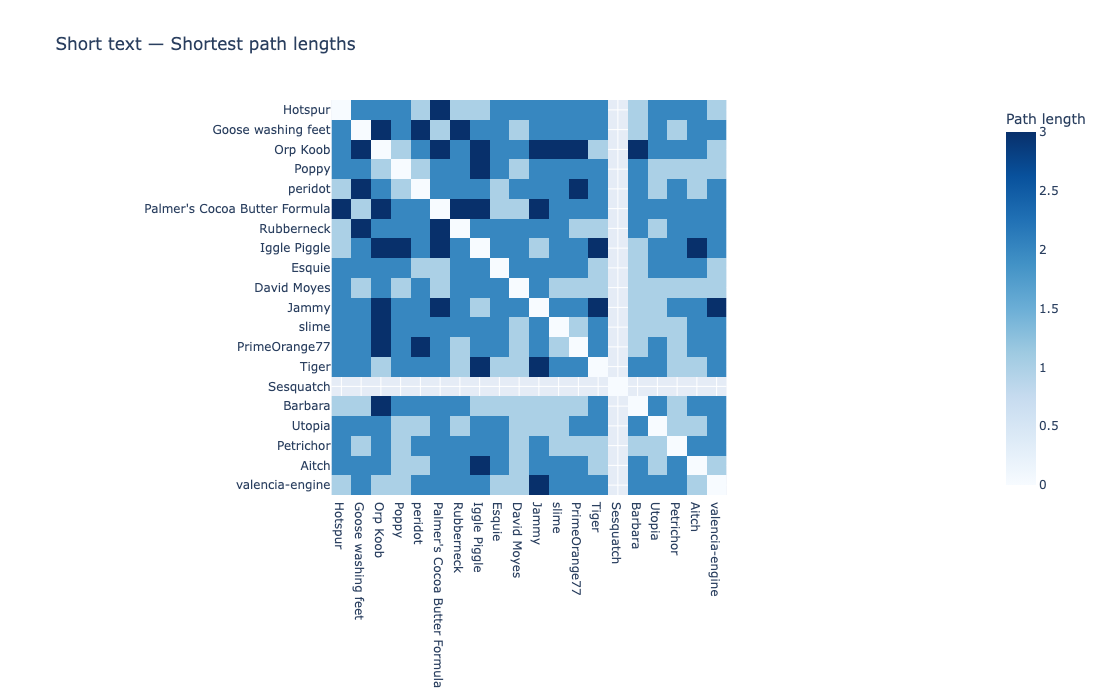


  Component 1: diameter = 3, average path length = 1.80

  Most distant reachable pair: Hotspur ↔ Palmer's Cocoa Butter Formula (path length 3)

  Unreachable pairs (19):
    Hotspur ↔ Sesquatch
    Goose washing feet ↔ Sesquatch
    Orp Koob ↔ Sesquatch
    Poppy ↔ Sesquatch
    peridot ↔ Sesquatch
    Palmer's Cocoa Butter Formula ↔ Sesquatch
    Rubberneck ↔ Sesquatch
    Iggle Piggle ↔ Sesquatch
    Esquie ↔ Sesquatch
    David Moyes ↔ Sesquatch
    ... and 9 more

------------------------------------------------------------

LONG-TEXT NETWORK
  Connected components: 10
    Component 1 (11 nodes): ['Aitch', 'Barbara', 'Goose washing feet', 'Hotspur', "Palmer's Cocoa Butter Formula", 'Petrichor', 'PrimeOrange77', 'Tiger', 'Utopia', 'slime', 'valencia-engine']
    Component 2 (1 nodes): ['Orp Koob']
    Component 3 (1 nodes): ['Poppy']
    Component 4 (1 nodes): ['peridot']
    Component 5 (1 nodes): ['Rubberneck']
    Component 6 (1 nodes): ['Iggle Piggle']
    Component 7 (1 nodes

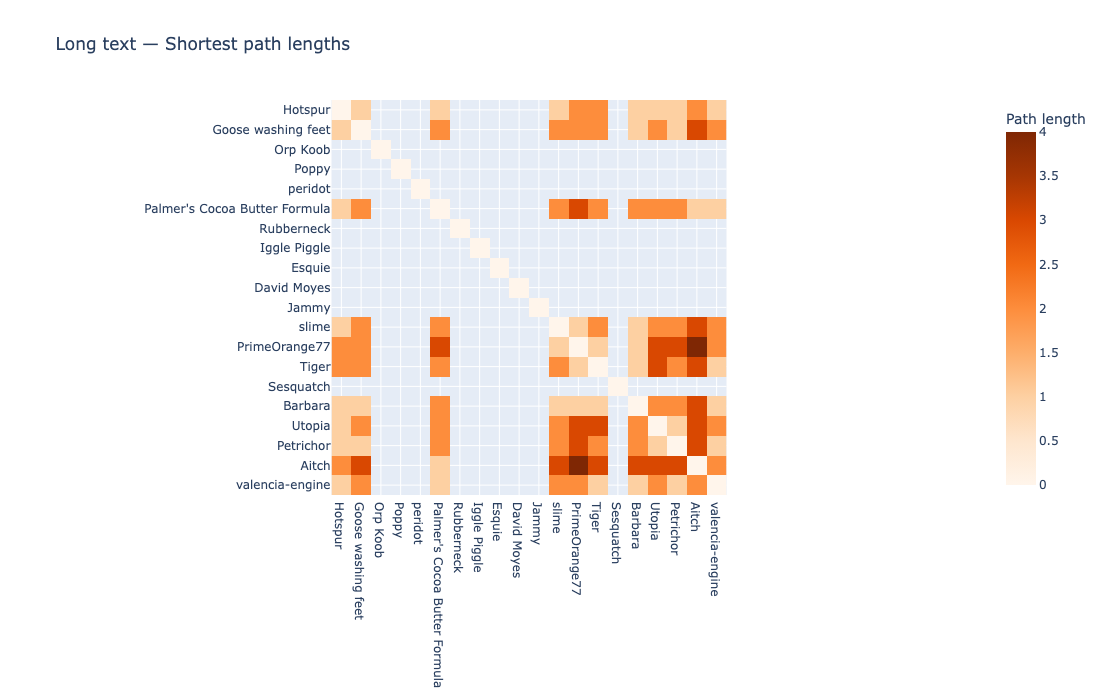


  Component 1: diameter = 4, average path length = 1.85

  Most distant reachable pair: PrimeOrange77 ↔ Aitch (path length 4)

  Unreachable pairs (135):
    Hotspur ↔ Orp Koob
    Hotspur ↔ Poppy
    Hotspur ↔ peridot
    Hotspur ↔ Rubberneck
    Hotspur ↔ Iggle Piggle
    Hotspur ↔ Esquie
    Hotspur ↔ David Moyes
    Hotspur ↔ Jammy
    Hotspur ↔ Sesquatch
    Goose washing feet ↔ Orp Koob
    ... and 125 more


In [48]:
# ── Applied: Paths & Distances in Student Networks ────────────────────────────

def path_analysis(G, label, cmap='Blues'):
    nodes = list(G.nodes())
    n = len(nodes)

    # Connected components
    components = list(nx.connected_components(G))
    print(f"  Connected components: {len(components)}")
    for i, comp in enumerate(sorted(components, key=len, reverse=True)):
        print(f"    Component {i+1} ({len(comp)} nodes): {sorted(comp)}")

    # Shortest path length matrix
    sp_matrix = np.full((n, n), np.inf)
    np.fill_diagonal(sp_matrix, 0)
    path_lengths = dict(nx.all_pairs_shortest_path_length(G))
    for i, n1 in enumerate(nodes):
        for j, n2 in enumerate(nodes):
            if n2 in path_lengths.get(n1, {}):
                sp_matrix[i, j] = path_lengths[n1][n2]

    # Replace inf with NaN for display
    sp_display = np.where(np.isinf(sp_matrix), np.nan, sp_matrix)

    fig = px.imshow(
        sp_display, x=nodes, y=nodes,
        color_continuous_scale=cmap,
        title=f'{label} — Shortest path lengths',
        labels=dict(color='Path length')
    )
    fig.update_layout(width=900, height=700)
    fig.show()

    # Diameter and average path length (per component)
    for i, comp in enumerate(sorted(components, key=len, reverse=True)):
        if len(comp) > 1:
            subG = G.subgraph(comp)
            diam = nx.diameter(subG)
            avg_pl = nx.average_shortest_path_length(subG)
            print(f"\n  Component {i+1}: diameter = {diam}, average path length = {avg_pl:.2f}")

    # Most/least reachable pairs
    finite_mask = np.isfinite(sp_matrix) & (sp_matrix > 0)
    if finite_mask.any():
        max_idx = np.unravel_index(np.where(finite_mask, sp_matrix, 0).argmax(), sp_matrix.shape)
        print(f"\n  Most distant reachable pair: {nodes[max_idx[0]]} ↔ {nodes[max_idx[1]]} "
              f"(path length {int(sp_matrix[max_idx])})")

    # Unreachable pairs
    unreachable = []
    for i in range(n):
        for j in range(i+1, n):
            if np.isinf(sp_matrix[i, j]):
                unreachable.append((nodes[i], nodes[j]))
    if unreachable:
        print(f"\n  Unreachable pairs ({len(unreachable)}):")
        for a, b in unreachable[:10]:
            print(f"    {a} ↔ {b}")
        if len(unreachable) > 10:
            print(f"    ... and {len(unreachable) - 10} more")


print("SHORT-TEXT NETWORK")
path_analysis(G_short, 'Short text', 'Blues')

print("\n" + "-" * 60)
print("\nLONG-TEXT NETWORK")
path_analysis(G_long, 'Long text', 'Oranges')

---

## 4. Clustering Coefficient

### Formal Definitions

- The **local clustering coefficient** of node $v$ measures how connected its neighbours are to each other:

$$C(v) = \frac{2 |\{\{u,w\} \in E : u,w \in N(v)\}|}{\deg(v)(\deg(v) - 1)}$$

where $N(v)$ is the set of neighbours of $v$. If $\deg(v) < 2$, we define $C(v) = 0$.

- The **global (average) clustering coefficient** is $\bar{C} = \frac{1}{n} \sum_{v \in V} C(v)$.
- **Transitivity** is the ratio of closed triplets to all triplets: $T = \frac{3 \times \text{triangles}}{\text{connected triples}}$.

High clustering means that "friends of friends tend to be friends" — or in our context, that students with similar writing tend to form tight clusters.

In [49]:
# ── Toy Example: Clustering Coefficient ──────────────────────────────────────
# Using our bridge graph:  A─B─C (triangle) ── D─E─F (triangle)
#
# C has 3 neighbours: A, B, D.
#   Of the 3 possible edges among {A, B, D}, only A–B exists.
#   So C(C) = 2·1 / (3·2) = 1/3 ≈ 0.333
#
# A has 2 neighbours: B, C.
#   The only possible edge among {B, C} is B–C, and it exists.
#   So C(A) = 2·1 / (2·1) = 1.0

print("Bridge graph — local clustering coefficients:")
print()
for node in sorted(G_bridge.nodes()):
    nbrs = sorted(G_bridge.neighbors(node))
    cc = nx.clustering(G_bridge, node)
    print(f"  {node}: C = {cc:.3f}  (neighbours: {', '.join(nbrs)})")

print(f"\nWorked example for C:")
print(f"  Neighbours of C: A, B, D")
print(f"  Possible edges among them: A–B, A–D, B–D  (3 possible)")
print(f"  Actual edges among them: A–B only  (1 actual)")
print(f"  C(C) = 2×1 / (3×2) = 0.333")
print(f"\nWorked example for A:")
print(f"  Neighbours of A: B, C")
print(f"  Possible edges among them: B–C  (1 possible)")
print(f"  Actual edges among them: B–C  (1 actual)")
print(f"  C(A) = 2×1 / (2×1) = 1.000")
print(f"\nA sits inside a tight triangle → C = 1.")
print(f"C and D bridge two clusters → lower C (not all their friends know each other).")
print(f"\nAverage clustering: {nx.average_clustering(G_bridge):.3f}")
print(f"Transitivity: {nx.transitivity(G_bridge):.3f}")

Bridge graph — local clustering coefficients:

  A: C = 1.000  (neighbours: B, C)
  B: C = 1.000  (neighbours: A, C)
  C: C = 0.333  (neighbours: A, B, D)
  D: C = 0.333  (neighbours: C, E, F)
  E: C = 1.000  (neighbours: D, F)
  F: C = 1.000  (neighbours: D, E)

Worked example for C:
  Neighbours of C: A, B, D
  Possible edges among them: A–B, A–D, B–D  (3 possible)
  Actual edges among them: A–B only  (1 actual)
  C(C) = 2×1 / (3×2) = 0.333

Worked example for A:
  Neighbours of A: B, C
  Possible edges among them: B–C  (1 possible)
  Actual edges among them: B–C  (1 actual)
  C(A) = 2×1 / (2×1) = 1.000

A sits inside a tight triangle → C = 1.
C and D bridge two clusters → lower C (not all their friends know each other).

Average clustering: 0.778
Transitivity: 0.600


SHORT-TEXT NETWORK


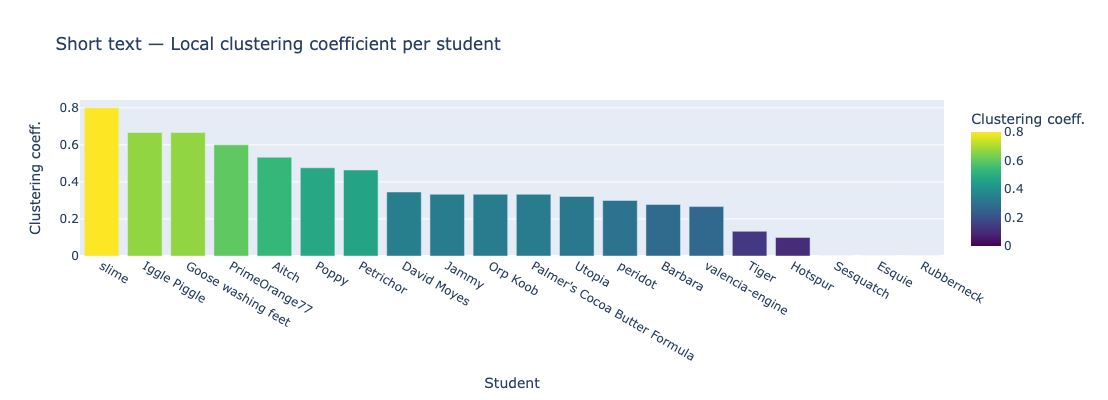

  Average clustering coefficient: 0.348
  Transitivity: 0.355

  Students in tight clusters (C > 0.5): slime, Iggle Piggle, Goose washing feet, PrimeOrange77, Aitch
  Potential bridges (low C, but connected): Barbara, valencia-engine, Tiger, Hotspur


,Clustering coeff.
slime,0.800000
Iggle Piggle,0.666667
Goose washing feet,0.666667
PrimeOrange77,0.600000
Aitch,0.533333
Poppy,0.476190
Petrichor,0.464286
David Moyes,0.345455
Jammy,0.333333
Orp Koob,0.333333



------------------------------------------------------------

LONG-TEXT NETWORK


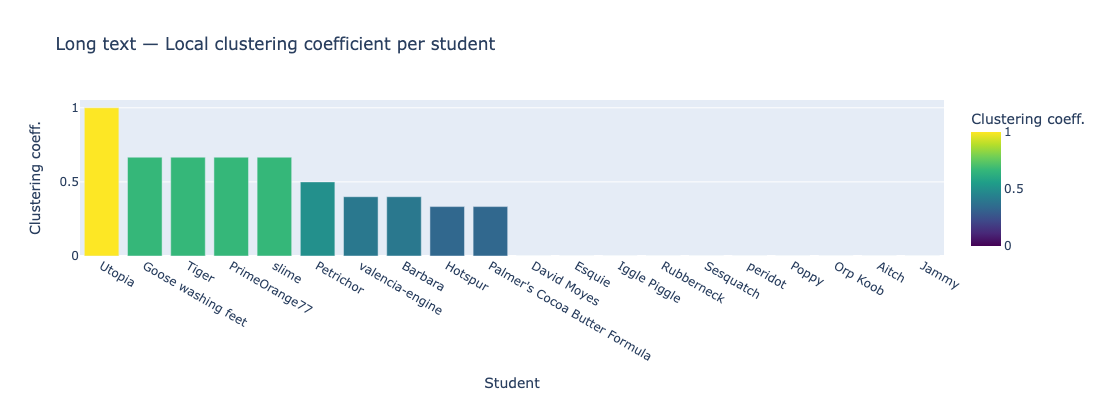

  Average clustering coefficient: 0.282
  Transitivity: 0.441

  Students in tight clusters (C > 0.5): Utopia, Goose washing feet, Tiger, PrimeOrange77, slime


,Clustering coeff.
Utopia,1.000000
Goose washing feet,0.666667
Tiger,0.666667
PrimeOrange77,0.666667
slime,0.666667
Petrichor,0.500000
valencia-engine,0.400000
Barbara,0.400000
Hotspur,0.333333
Palmer's Cocoa Butter Formula,0.333333


In [50]:
# ── Applied: Clustering Coefficient in Student Networks ───────────────────────

def clustering_analysis(G, label, color):
    cc = nx.clustering(G)
    cc_df = pd.DataFrame.from_dict(cc, orient='index', columns=['Clustering coeff.'])
    cc_df = cc_df.sort_values('Clustering coeff.', ascending=False)

    fig = px.bar(
        cc_df.reset_index(), x='index', y='Clustering coeff.',
        title=f'{label} — Local clustering coefficient per student',
        labels={'index': 'Student'},
        color='Clustering coeff.', color_continuous_scale='Viridis'
    )
    fig.update_layout(width=700, height=400)
    fig.show()

    avg_cc = nx.average_clustering(G)
    trans = nx.transitivity(G)
    print(f"  Average clustering coefficient: {avg_cc:.3f}")
    print(f"  Transitivity: {trans:.3f}")

    # Interpretation
    high_cc = cc_df[cc_df['Clustering coeff.'] > 0.5]
    if not high_cc.empty:
        print(f"\n  Students in tight clusters (C > 0.5): {', '.join(high_cc.index)}")

    bridges = cc_df[(cc_df['Clustering coeff.'] < 0.3) &
                    (cc_df['Clustering coeff.'] > 0)]
    if not bridges.empty:
        print(f"  Potential bridges (low C, but connected): {', '.join(bridges.index)}")

    display(cc_df)
    return cc_df


print("SHORT-TEXT NETWORK")
cc_short = clustering_analysis(G_short, 'Short text', '#4a90d9')

print("\n" + "-" * 60)
print("\nLONG-TEXT NETWORK")
cc_long = clustering_analysis(G_long, 'Long text', '#d97a4a')

---

## 5. Centrality and Outliers

### Formal Definitions

Centrality measures quantify how "important" or "influential" a node is within the network. Different measures capture different notions of importance:

- **Degree centrality**: $C_D(v) = \frac{\deg(v)}{n - 1}$ — fraction of possible connections realised. High degree centrality = connected to many others.

- **Betweenness centrality**: $C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$ where $\sigma_{st}$ is the number of shortest paths from $s$ to $t$, and $\sigma_{st}(v)$ is the number that pass through $v$. High betweenness = sits on many shortest paths (a "bridge" or "gatekeeper").

- **Closeness centrality**: $C_C(v) = \frac{n - 1}{\sum_{u \neq v} d(v, u)}$ — inverse of average distance to all other nodes. High closeness = can reach everyone quickly.

- **Eigenvector centrality**: solves $A\mathbf{x} = \lambda \mathbf{x}$ — a node is important if it is connected to other important nodes.

In [51]:
# ── Toy Example: Centrality ──────────────────────────────────────────────────
# Using the bridge graph: A─B─C (triangle) ── D─E─F (triangle)
# This graph makes the differences between centrality measures vivid.

toy_cent = pd.DataFrame({
    'Degree':      nx.degree_centrality(G_bridge),
    'Betweenness': nx.betweenness_centrality(G_bridge),
    'Closeness':   nx.closeness_centrality(G_bridge),
    'Eigenvector':  nx.eigenvector_centrality(G_bridge),
}).round(3)

print("Bridge graph — centrality measures:")
display(toy_cent)

print("\nKey observations:")
print("  • Degree centrality: C and D have the most connections (3 each).")
print("  • Betweenness: C and D dominate — every shortest path between the two")
print("    triangles must pass through them. They are gatekeepers.")
print("  • Closeness: C and D are closest to everyone on average.")
print("  • Eigenvector: C and D score highest — they're connected to each other")
print("    (both important), while A is only connected to B and C.")
print("\nIn this symmetric graph, all four measures agree. In real networks,")
print("they often diverge — a node can be a bridge (high betweenness) without")
print("having many connections (low degree).")

Bridge graph — centrality measures:


,Degree,Betweenness,Closeness,Eigenvector
A,0.4,0.0,0.500,0.354
B,0.4,0.0,0.500,0.354
C,0.6,0.6,0.714,0.500
D,0.6,0.6,0.714,0.500
E,0.4,0.0,0.500,0.354
F,0.4,0.0,0.500,0.354



Key observations:
  • Degree centrality: C and D have the most connections (3 each).
  • Betweenness: C and D dominate — every shortest path between the two
    triangles must pass through them. They are gatekeepers.
  • Closeness: C and D are closest to everyone on average.
  • Eigenvector: C and D score highest — they're connected to each other
    (both important), while A is only connected to B and C.

In this symmetric graph, all four measures agree. In real networks,
they often diverge — a node can be a bridge (high betweenness) without
having many connections (low degree).


SHORT-TEXT NETWORK


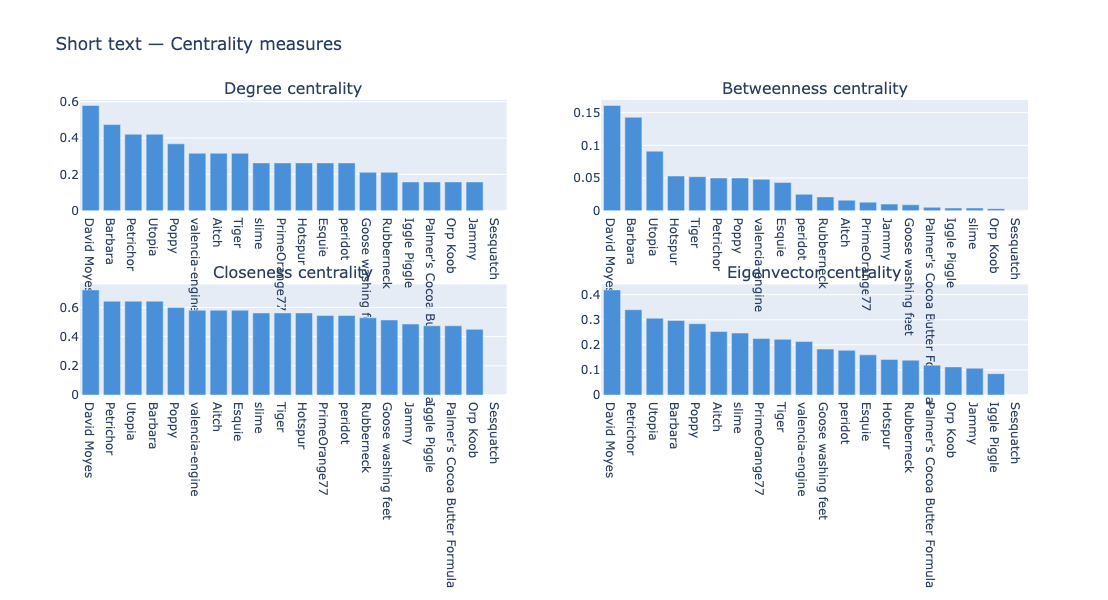

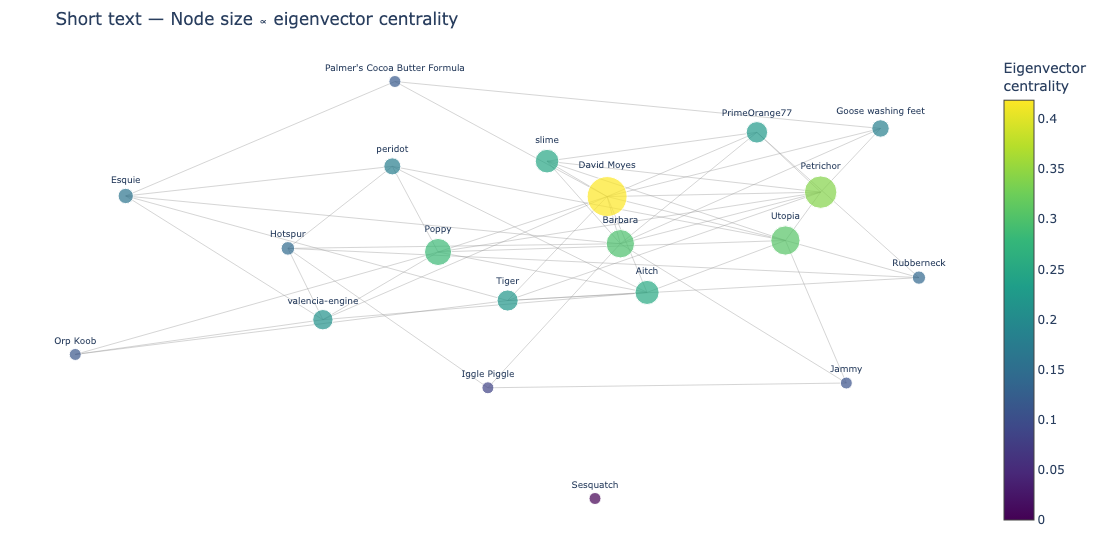


  Most central (by eigenvector): David Moyes (0.419)
  Most central (by betweenness): David Moyes (0.161)
  Isolated nodes (degree 0): Sesquatch
  Peripheral nodes (bottom 25% degree): Orp Koob, Palmer's Cocoa Butter Formula, Iggle Piggle, Jammy, Sesquatch


,Degree,Betweenness,Closeness,Eigenvector
David Moyes,0.579,0.161,0.720,0.419
Petrichor,0.421,0.050,0.643,0.340
Utopia,0.421,0.091,0.643,0.306
Barbara,0.474,0.143,0.643,0.297
Poppy,0.368,0.050,0.600,0.284
Aitch,0.316,0.016,0.581,0.253
slime,0.263,0.004,0.562,0.247
PrimeOrange77,0.263,0.013,0.545,0.225
Tiger,0.316,0.052,0.562,0.222
valencia-engine,0.316,0.048,0.581,0.213



------------------------------------------------------------

LONG-TEXT NETWORK


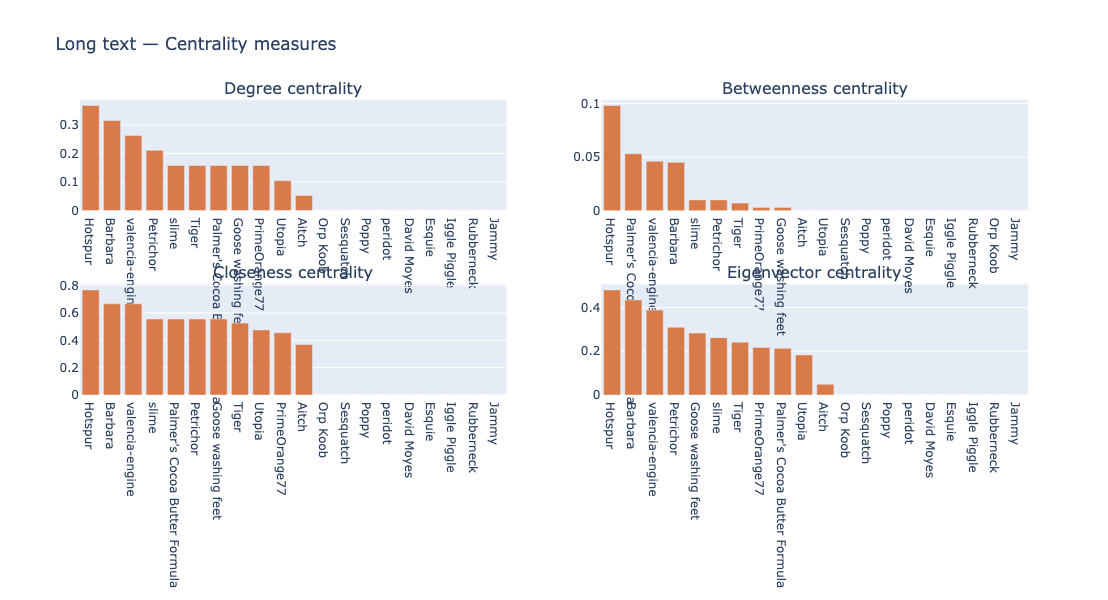

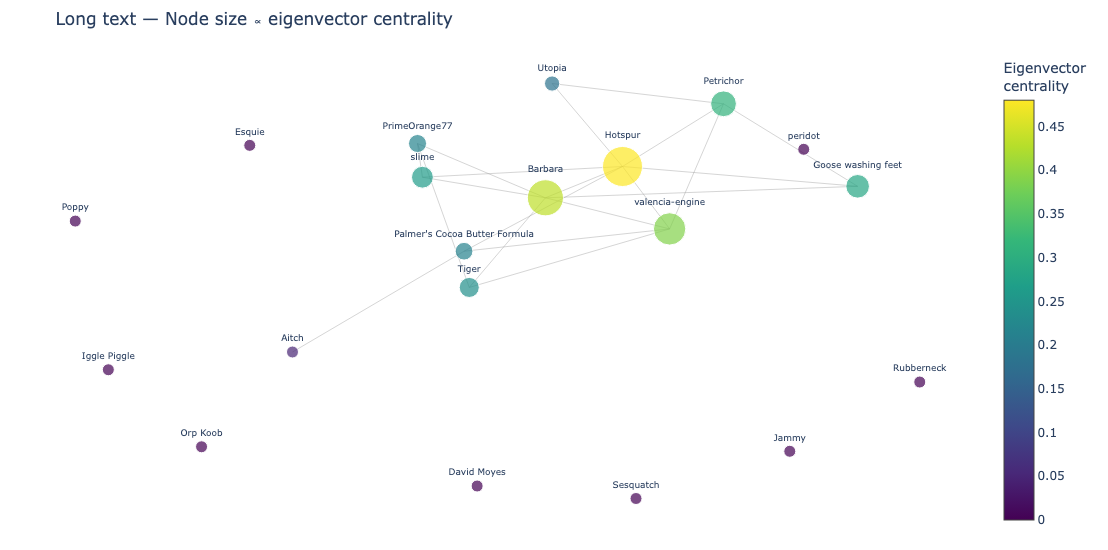


  Most central (by eigenvector): Hotspur (0.480)
  Most central (by betweenness): Hotspur (0.098)
  Isolated nodes (degree 0): Orp Koob, Poppy, peridot, Rubberneck, Iggle Piggle, Esquie, David Moyes, Jammy, Sesquatch
  Peripheral nodes (bottom 25% degree): Orp Koob, Poppy, peridot, Rubberneck, Iggle Piggle, Esquie, David Moyes, Jammy, Sesquatch


,Degree,Betweenness,Closeness,Eigenvector
Hotspur,0.368,0.098,0.769,0.480
Barbara,0.316,0.045,0.667,0.434
valencia-engine,0.263,0.046,0.667,0.388
Petrichor,0.211,0.010,0.556,0.309
Goose washing feet,0.158,0.003,0.556,0.283
slime,0.158,0.010,0.556,0.262
Tiger,0.158,0.007,0.526,0.241
PrimeOrange77,0.158,0.003,0.455,0.217
Palmer's Cocoa Butter Formula,0.158,0.053,0.556,0.213
Utopia,0.105,0.000,0.476,0.183


In [52]:
# ── Applied: Centrality & Outliers in Student Networks ────────────────────────

def centrality_analysis(G, sim_df, label, color):
    nodes = list(G.nodes())

    # Compute centralities
    deg_c = nx.degree_centrality(G)
    bet_c = nx.betweenness_centrality(G)
    # Closeness: handle disconnected graphs
    clo_c = {}
    for comp in nx.connected_components(G):
        subG = G.subgraph(comp)
        if len(comp) > 1:
            sub_clo = nx.closeness_centrality(subG)
            clo_c.update(sub_clo)
        else:
            for n in comp:
                clo_c[n] = 0.0
    # Eigenvector centrality: handle disconnected graphs
    eig_c = {}
    for comp in nx.connected_components(G):
        subG = G.subgraph(comp)
        if len(comp) > 1:
            try:
                sub_eig = nx.eigenvector_centrality(subG, max_iter=1000)
            except nx.PowerIterationFailedConvergence:
                sub_eig = {n: 0.0 for n in comp}
            eig_c.update(sub_eig)
        else:
            for n in comp:
                eig_c[n] = 0.0

    cent_df = pd.DataFrame({
        'Degree': deg_c,
        'Betweenness': bet_c,
        'Closeness': clo_c,
        'Eigenvector': eig_c
    }).round(3)

    # Bar chart comparison
    fig = make_subplots(rows=2, cols=2,
                        subplot_titles=['Degree centrality', 'Betweenness centrality',
                                        'Closeness centrality', 'Eigenvector centrality'])
    for idx, col in enumerate(cent_df.columns):
        row, c = divmod(idx, 2)
        sorted_df = cent_df.sort_values(col, ascending=False)
        fig.add_trace(
            go.Bar(x=sorted_df.index, y=sorted_df[col], name=col,
                   marker_color=color, showlegend=False),
            row=row+1, col=c+1
        )
    fig.update_layout(title=f'{label} — Centrality measures', width=800, height=600)
    fig.show()

    # Network with node size ∝ eigenvector centrality
    pos = nx.spring_layout(G, seed=42, k=2/np.sqrt(max(len(G), 1)))
    edge_traces = []
    for u, v, d in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_traces.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            mode='lines',
            line=dict(width=1, color='rgba(150,150,150,0.4)'),
            hoverinfo='none', showlegend=False
        ))

    eig_vals = [eig_c.get(n, 0) for n in G.nodes()]
    max_eig = max(eig_vals) if max(eig_vals) > 0 else 1
    node_sizes = [max(12, 40 * e / max_eig) for e in eig_vals]

    node_trace = go.Scatter(
        x=[pos[n][0] for n in G.nodes()],
        y=[pos[n][1] for n in G.nodes()],
        mode='markers+text',
        text=list(G.nodes()),
        textposition='top center', textfont=dict(size=9),
        marker=dict(
            size=node_sizes,
            color=eig_vals,
            colorscale='Viridis',
            showscale=True,
            colorbar=dict(title='Eigenvector<br>centrality'),
            line=dict(width=1, color='white')
        ),
        hovertext=[f"{n}\nEigenvector: {eig_c.get(n,0):.3f}\n"
                   f"Degree: {deg_c[n]:.3f}\nBetweenness: {bet_c[n]:.3f}"
                   for n in G.nodes()],
        hoverinfo='text', showlegend=False
    )

    fig2 = go.Figure(data=edge_traces + [node_trace])
    fig2.update_layout(
        title=f'{label} — Node size ∝ eigenvector centrality',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=750, height=550, margin=dict(l=20, r=20, t=50, b=20),
        plot_bgcolor='white'
    )
    fig2.show()

    # Identify hubs and outliers
    print(f"\n  Most central (by eigenvector): "
          f"{cent_df['Eigenvector'].idxmax()} ({cent_df['Eigenvector'].max():.3f})")
    print(f"  Most central (by betweenness): "
          f"{cent_df['Betweenness'].idxmax()} ({cent_df['Betweenness'].max():.3f})")

    isolated = [n for n in G.nodes() if G.degree(n) == 0]
    if isolated:
        print(f"  Isolated nodes (degree 0): {', '.join(isolated)}")

    peripheral = cent_df[cent_df['Degree'] <= cent_df['Degree'].quantile(0.25)]
    if not peripheral.empty:
        print(f"  Peripheral nodes (bottom 25% degree): {', '.join(peripheral.index)}")

    display(cent_df.sort_values('Eigenvector', ascending=False))
    return cent_df


print("SHORT-TEXT NETWORK")
cent_short = centrality_analysis(G_short, sim_short, 'Short text', '#4a90d9')

print("\n" + "-" * 60)
print("\nLONG-TEXT NETWORK")
cent_long = centrality_analysis(G_long, sim_long, 'Long text', '#d97a4a')

---

## Comparison & Reflection

In [53]:
# ── Comparison & Reflection ──────────────────────────────────────────────────

# ── Side-by-side summary ─────────────────────────────────────────────────────
comparison = pd.DataFrame({
    'Short-text network': {
        'Nodes': G_short.number_of_nodes(),
        'Edges': G_short.number_of_edges(),
        'Threshold': THRESH_SHORT,
        'Density': f"{nx.density(G_short):.3f}",
        'Components': nx.number_connected_components(G_short),
        'Avg clustering': f"{nx.average_clustering(G_short):.3f}",
        'Transitivity': f"{nx.transitivity(G_short):.3f}",
    },
    'Long-text network': {
        'Nodes': G_long.number_of_nodes(),
        'Edges': G_long.number_of_edges(),
        'Threshold': THRESH_LONG,
        'Density': f"{nx.density(G_long):.3f}",
        'Components': nx.number_connected_components(G_long),
        'Avg clustering': f"{nx.average_clustering(G_long):.3f}",
        'Transitivity': f"{nx.transitivity(G_long):.3f}",
    }
})
print("Network Comparison")
display(comparison)

# ── Do the same students occupy similar positions? ────────────────────────────
print("\n── Centrality correlation across networks ──")
common_nodes = sorted(set(cent_short.index) & set(cent_long.index))
for measure in ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']:
    s = cent_short.loc[common_nodes, measure]
    l = cent_long.loc[common_nodes, measure]
    corr = s.corr(l)
    print(f"  {measure:15s} Pearson r = {corr:+.3f}")

print("\nPositive correlations suggest students occupy similar positions in both ")
print("networks — their short self-description aligns with their longer writing.")
print("Low or negative correlations suggest the two texts reveal different facets ")
print("of intellectual identity.")

# ── Rank comparison ──────────────────────────────────────────────────────────
rank_df = pd.DataFrame({
    'Short-text eigenvector rank': cent_short.loc[common_nodes, 'Eigenvector']
        .rank(ascending=False).astype(int),
    'Long-text eigenvector rank': cent_long.loc[common_nodes, 'Eigenvector']
        .rank(ascending=False).astype(int),
})
rank_df['Rank change'] = rank_df.iloc[:, 0] - rank_df.iloc[:, 1]
display(rank_df.sort_values('Short-text eigenvector rank'))

# ── Fun appendix: student-submitted questions ────────────────────────────────
print("\n" + "=" * 60)
print("APPENDIX: Questions submitted by cohort members")
print("=" * 60)
for _, row in df.iterrows():
    q = row['question']
    if pd.notna(q) and str(q).strip() and str(q).strip().lower() not in ('nan', 'answer'):
        print(f"  {row['pseudonym']}: \"{q}\"")

Network Comparison


,Short-text network,Long-text network
Nodes,20,20
Edges,53,20
Threshold,0.06,0.06
Density,0.279,0.105
Components,2,10
Avg clustering,0.348,0.282
Transitivity,0.355,0.441



── Centrality correlation across networks ──
  Degree          Pearson r = +0.282
  Betweenness     Pearson r = +0.180
  Closeness       Pearson r = +0.301
  Eigenvector     Pearson r = +0.256

Positive correlations suggest students occupy similar positions in both 
networks — their short self-description aligns with their longer writing.
Low or negative correlations suggest the two texts reveal different facets 
of intellectual identity.


,Short-text eigenvector rank,Long-text eigenvector rank,Rank change
David Moyes,1,16,-15
Petrichor,2,4,-2
Utopia,3,10,-7
Barbara,4,2,2
Poppy,5,16,-11
Aitch,6,11,-5
slime,7,6,1
PrimeOrange77,8,8,0
Tiger,9,7,2
valencia-engine,10,3,7



APPENDIX: Questions submitted by cohort members
  Hotspur: "42"
  Goose washing feet: "Who is most likely to get married first?"
  Orp Koob: "Would it benefit us to control our emotions more?"
  Poppy: "Who’s is best able to empathise and represent the cohorts perspectives and views"
  Palmer's Cocoa Butter Formula: "What does a nosey pepper do? It gets jalapeno business. "
  Iggle Piggle: "How does it feel?"
  Sesquatch: "How do relationships improve with shared aims, focussing on better possible futures?"
  Utopia: "What belief, assumption, or pattern have you changed your mind about in recent years, and what led to that change?"
  Petrichor: "Yes, question everything."
  Aitch: "Usually the answer is cake."
